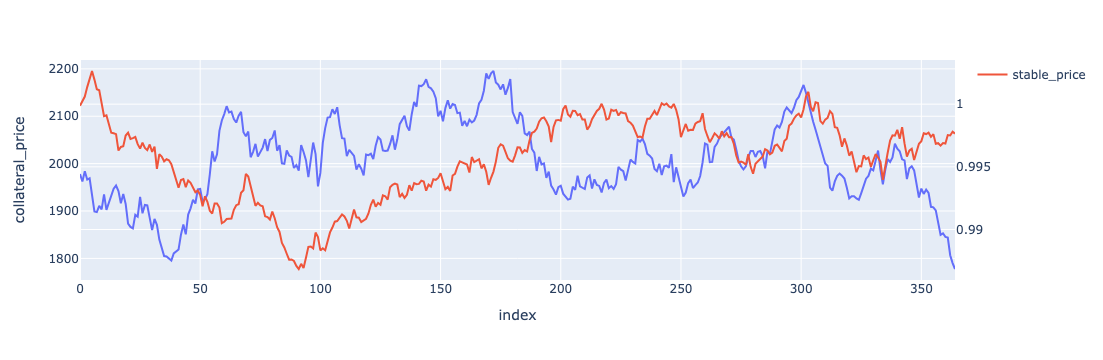

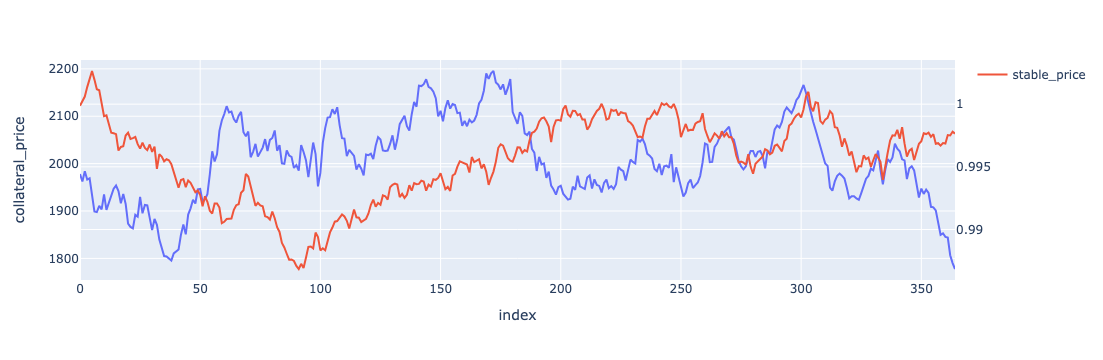

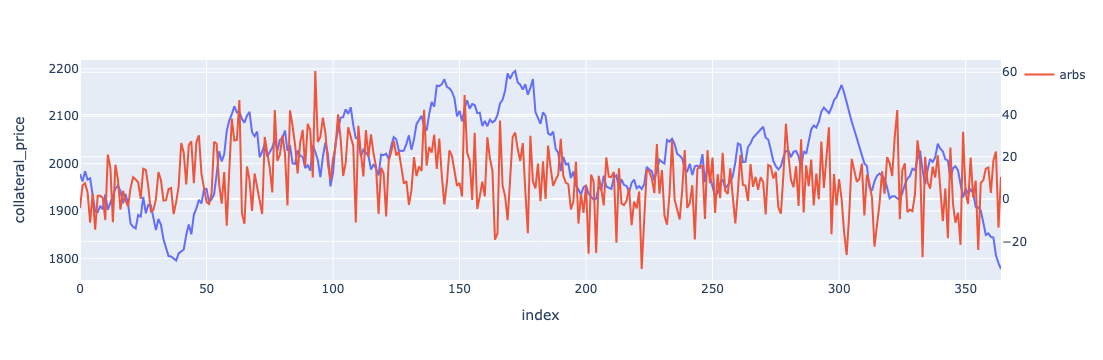

In [25]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

# generate stochastic price path
def gen_gbm(S0,mu,sigma, dt, T):
    W = np.random.normal(loc=0, scale=np.sqrt(dt), size=int(T / dt))
    S = S0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * W))
    return(S)

# mint and burn affects interest rate and stable oracle price
def peg_keeper(stable_price, peg_strength=.2):
    # it will only allow you to mint more tokens, if the peg keeper is off int eh same direction as all other peg keeper
    # we want p_agg to exclude the current pool 
    # is this liquidity weighted, check monetary policy contract?
    return( np.vectorize(lambda x:(peg-x)*peg_strength)(stable_price) )

# oracle price = collateral / stable
def llamma(p_oracle,p_amm,arb_profitability = .95):
    arb_opp = arb_profitability*(p_oracle - p_amm)
    return(arb_opp)

# Graphing
def graph(df,y1: str,y2: int =False):
    if y2!=False:
        fig = px.line(df,x=df.index,y=y1,labels={'X':'Timestep',"Y":y1})
        fig.add_trace(go.Scatter(x=df.index, y=df[y2], mode='lines',name=y2,yaxis="y2"))
        fig.update_layout(yaxis2=dict(overlaying='y',side='right'))
        fig.show()
    else:
        fig = px.line(df,x=df.index,y=y1,labels={'X':'Timestep',"Y":y1})
        fig.show()

def sim():
    # Generate stochastic price paths
    df["collateral_price"] = gen_gbm(S0=2000,mu=0.05, sigma=0.2, dt=1/365,T=1)
    df["stable_price"] = gen_gbm(S0=1,mu=0.0, sigma=0.01, dt=1/365,T=1)
    
    # Peg Keeper
    df["mint_burn"] = peg_keeper(stable_price,peg_strength=.2)
    
    # LLAMMA
    df["p_market"] = np.vectorize(lambda x:x*np.random.normal(1,.005))(df["collateral_price"])
    df["p_oracle"] = df["p_market"]/df["stable_price"]
    df["p_amm"] = np.vectorize(lambda x:x*np.random.normal(1,.005))(df["collateral_price"])
    df["arbs"] = llamma(df["p_oracle"],df["p_amm"],arb_profitability = .95)
    
    # Dataframe
    df["losses"] = 100*np.sqrt(.05*abs(df["arbs"])/df["collateral_price"])
    return(df)

# Graphing
graph(df,y1="collateral_price",y2="stable_price")
graph(df,y1="collateral_price",y2="stable_price")
graph(df,y1="collateral_price",y2="arbs")

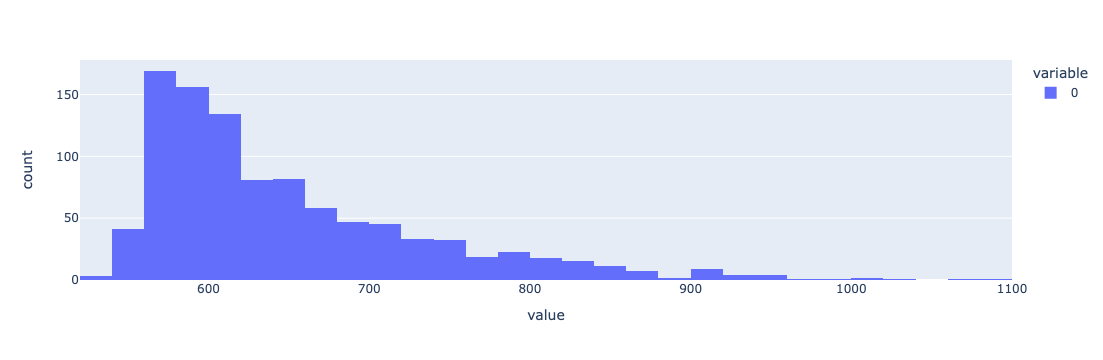

In [26]:
agg_results = []

for i in range(1000):
    df = sim()
    losses = df["losses"].sum()
    agg_results+=[losses]

fig = px.histogram(agg_results)

# Show the plot
fig.show()